# Data Preprocessing

## Load Data

In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [37]:
import os

# Define the HuggingFace repository and local path
ct_filename = "ct.nii.gz"
pancreas_segmentations_filename = "segmentations/pancreas.nii.gz"

data_folder = "./data"
encoded_images_dir = os.path.join(data_folder, "encoded_imgs")

os.path.join(encoded_images_dir, 'enc_healthy_cubes.pkl')
import pickle

with open(os.path.join(encoded_images_dir, 'enc_healthy_cubes.pkl'), 'rb') as f:
    enc_healthy_cubes = pickle.load(f)

with open(os.path.join(encoded_images_dir, 'enc_pancreatic_tumor_cubes.pkl'), 'rb') as f:
    enc_pancreatic_tumor_cubes = pickle.load(f)

In [38]:
len(enc_healthy_cubes.values())

42

## Unfortunately some of the CTs have less than 10 samples bcs. they ended up being out of range

- [ ] TODO Reduce to min. no. samples of all CTs

In [39]:
import torch

def process_and_stack_tensors(enc_pancreatic_tumor_cubes):
    """
    Process the tensors in the dictionary:
    1. Stack the tensors, ignoring empty lists.
    2. Take tensors with at least 5 entries along the first dimension.
    3. Threshold them to 5 entries, dropping those with fewer than 5 entries.
    4. Stack all the processed tensors along a new axis.

    Parameters:
    enc_pancreatic_tumor_cubes (dict): The input dictionary with lists of tensors.

    Returns:
    torch.Tensor: A tensor with all the processed tensors stacked along a new axis.
    """
    # Stack the tensors, ignoring empty lists
    stacked_inner_lists = [torch.stack(inner_list).squeeze(1) for inner_list in enc_pancreatic_tumor_cubes.values() if inner_list]

    # Filter and reduce the tensors to have exactly 5 entries along the first dimension
    filtered_and_reduced_tensors = [tensor[:5] for tensor in stacked_inner_lists if tensor.shape[0] >= 5]

    # Stack all the processed tensors along a new axis
    if filtered_and_reduced_tensors:
        final_tensor = torch.stack(filtered_and_reduced_tensors)
    else:
        final_tensor = torch.tensor([])  # Return an empty tensor if no tensors meet the criteria

    return final_tensor

In [40]:
enc_pancreatic_tensors = process_and_stack_tensors(enc_pancreatic_tumor_cubes)
enc_healthy_tensors = process_and_stack_tensors(enc_healthy_cubes)

print(enc_pancreatic_tensors.shape)
print(enc_healthy_tensors.shape)

torch.Size([13, 5, 8, 24, 24, 24])
torch.Size([42, 5, 8, 24, 24, 24])


In [41]:
final_tensor = torch.cat([enc_healthy_tensors, enc_pancreatic_tensors], dim=0)
final_tensor.shape

torch.Size([55, 5, 8, 24, 24, 24])

In [42]:
healthy_labels = torch.zeros(enc_healthy_tensors.shape[0])
pancreatic_labels = torch.ones(enc_pancreatic_tensors.shape[0])

final_labels = torch.cat([healthy_labels, pancreatic_labels], dim=0)
final_labels.shape

torch.Size([55])

In [43]:
features = final_tensor
labels = final_labels

## Apply scaling and Flattening

In [45]:
def flatten_and_scale_features(features):
    """
    Flatten and standardize the features.

    Parameters:
        features (numpy.ndarray): Original features of shape (n_samples, ...).

    Returns:
        numpy.ndarray: Flattened and standardized features of shape (n_samples, n_features_flat).
    """
    n_samples = features.shape[0]
    flattened_features = features.reshape(n_samples, -1)
    scaler = StandardScaler()
    flattened_features_std = scaler.fit_transform(flattened_features)
    return flattened_features_std

In [46]:
# Assuming 'features' is your data of shape (n_samples, 8, 24, 24, 24)
# and 'labels' contains the labels (0 for healthy, 1 for unhealthy)
# Load or generate your 'features' and 'labels' here

# Flatten and scale features
flattened_features_std = flatten_and_scale_features(features)

# Dimensionality Reduction and Clustering

## Function Definitions

### Dimensionality Reduction

In [55]:
def apply_pca(features, n_components):
    """
    Apply PCA to reduce dimensionality.

    Parameters:
        features (numpy.ndarray): Input features.
        n_components (int): Number of components to retain.

    Returns:
        numpy.ndarray: PCA-transformed features.
        float: Total explained variance ratio.
    """
    pca = PCA(n_components=n_components, random_state=42)
    features_pca = pca.fit_transform(features)
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return features_pca, explained_variance

def apply_tsne(features, n_components, perplexity=30):
    """
    Apply t-SNE to reduce dimensionality.

    Parameters:
        features (numpy.ndarray): Input features.
        n_components (int): Target number of dimensions.
        perplexity (float): Perplexity parameter for t-SNE.

    Returns:
        numpy.ndarray: t-SNE-transformed features.
    """
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=42)
    features_tsne = tsne.fit_transform(features)
    return features_tsne

def apply_umap(features, n_components, n_neighbors=15, min_dist=0.1):
    """
    Apply UMAP to reduce dimensionality.

    Parameters:
        features (numpy.ndarray): Input features.
        n_components (int): Target number of dimensions.
        n_neighbors (int): Number of neighbors for UMAP.
        min_dist (float): Minimum distance parameter for UMAP.

    Returns:
        numpy.ndarray: UMAP-transformed features.
    """
    umap_reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=42
    )
    features_umap = umap_reducer.fit_transform(features)
    return features_umap

### Clustering

In [57]:
def cluster_and_evaluate(features, method, n_clusters, **kwargs):
    """
    Perform clustering and evaluate performance.

    Parameters:
        features (numpy.ndarray): Input features for clustering.
        method (str): Clustering method ('kmeans', 'agglomerative', 'gmm').
        n_clusters (int): Number of clusters.
        **kwargs: Additional keyword arguments for clustering algorithms.

    Returns:
        dict: A dictionary containing evaluation metrics.
    """
    if method == 'kmeans':
        clustering = KMeans(n_clusters=n_clusters, random_state=42, **kwargs)
        clusters = clustering.fit_predict(features)
    elif method == 'agglomerative':
        clustering = AgglomerativeClustering(n_clusters=n_clusters, **kwargs)
        clusters = clustering.fit_predict(features)
    elif method == 'gmm':
        clustering = GaussianMixture(n_components=n_clusters, random_state=42, **kwargs)
        clusters = clustering.fit_predict(features)
    else:
        raise ValueError(f"Unsupported clustering method: {method}")

    # Evaluate clustering performance
    if len(set(clusters)) > 1 and len(set(clusters)) < len(features):
        silhouette_avg = silhouette_score(features, clusters)
        calinski_harabasz = calinski_harabasz_score(features, clusters)
        davies_bouldin = davies_bouldin_score(features, clusters)
    else:
        silhouette_avg = calinski_harabasz = davies_bouldin = np.nan

    evaluation = {
        'Silhouette Score': silhouette_avg,
        'Calinski-Harabasz Score': calinski_harabasz,
        'Davies-Bouldin Score': davies_bouldin
    }
    return evaluation


def evaluate_clustering(features, labels):
    """
    Evaluate clustering performance across different dimensionality reduction and clustering methods.

    Parameters:
        features (numpy.ndarray): Original high-dimensional features.
        labels (numpy.ndarray): True labels (if available, not used in clustering).

    Returns:
        dict: Nested dictionaries containing DataFrames of evaluation metrics.
    """
    # Define parameter ranges
    n_components_list = list(range(2, 56, 5))  # From 2 to 55 in steps of 5
    n_clusters_list = list(range(2, 8))        # From 2 to 7 in steps of 1

    dim_reduction_methods = ['PCA', 't-SNE', 'UMAP']
    clustering_methods = ['kmeans', 'agglomerative', 'gmm']

    # Initialize results dictionary
    results = {}

    for dim_name in dim_reduction_methods:
        print(f"\nDimensionality Reduction Method: {dim_name}")

        # Initialize a nested dictionary to store results
        results[dim_name] = {}

        for n_components in n_components_list:
            if dim_name == 't-SNE' and n_components > 3:
                continue

            print(f"  n_components = {n_components}")

            # Apply dimensionality reduction
            if dim_name == 'PCA':
                reduced_features, explained_variance = apply_pca(features, n_components)
                print(f"    Explained Variance Ratio: {explained_variance:.4f}")
            elif dim_name == 't-SNE':
                # Adjust perplexity if necessary based on n_components and sample size
                reduced_features = apply_tsne(features, n_components=n_components)
            elif dim_name == 'UMAP':
                reduced_features = apply_umap(features, n_components=n_components)

            # Initialize DataFrame for this n_components
            key = f"n_components_{n_components}"
            results[dim_name][key] = pd.DataFrame(
                index=n_clusters_list,
                columns=clustering_methods
            )

            for n_clusters in n_clusters_list:
                for method in clustering_methods:
                    # Perform clustering and evaluation
                    evaluation = cluster_and_evaluate(
                        reduced_features,
                        method=method,
                        n_clusters=n_clusters
                    )
                    # Store Silhouette Score in the DataFrame
                    results[dim_name][key].loc[n_clusters, method] = evaluation['Silhouette Score']

        print("  Evaluation complete.")

    return results

## Evaluation 🧪

In [58]:
# Run the evaluation
results = evaluate_clustering(flattened_features_std, labels)


Dimensionality Reduction Method: PCA
  n_components = 2
    Explained Variance Ratio: 0.0840
  n_components = 7
    Explained Variance Ratio: 0.2058
  n_components = 12
    Explained Variance Ratio: 0.3135
  n_components = 17
    Explained Variance Ratio: 0.4137
  n_components = 22
    Explained Variance Ratio: 0.5102
  n_components = 27
    Explained Variance Ratio: 0.6004
  n_components = 32
    Explained Variance Ratio: 0.6866
  n_components = 37
    Explained Variance Ratio: 0.7697
  n_components = 42
    Explained Variance Ratio: 0.8466
  n_components = 47
    Explained Variance Ratio: 0.9179
  n_components = 52
    Explained Variance Ratio: 0.9793
  Evaluation complete.

Dimensionality Reduction Method: t-SNE
  n_components = 2
  Evaluation complete.

Dimensionality Reduction Method: UMAP
  n_components = 2
  n_components = 7
  n_components = 12
  n_components = 17
  n_components = 22
  n_components = 27
  n_components = 32
  n_components = 37
  n_components = 42
  n_components 

In [60]:
# Display the results for each dimensionality reduction method and n_components
for dim_name, components_dict in results.items():
    print(f"\nResults for {dim_name}:\n")
    for n_components_key, df in components_dict.items():
        print(f"n_components = {n_components_key.split('_')[-1]}")
        print(df)
        print("\n")


Results for PCA:

n_components = 2
     kmeans agglomerative       gmm
2  0.415781      0.403015  0.412469
3  0.471768      0.435367  0.471768
4   0.42468      0.325491  0.207349
5  0.372024      0.324841  0.187038
6  0.369312      0.364407  0.176826
7  0.378918      0.365611  0.268334


n_components = 7
     kmeans agglomerative       gmm
2  0.197427      0.178406  0.247093
3  0.196978      0.186267  0.243406
4  0.207885      0.210924  0.215972
5  0.235804       0.23825  0.091066
6  0.222924      0.260684  0.091944
7  0.245807      0.264427  0.100665


n_components = 12
     kmeans agglomerative       gmm
2  0.128265      0.125084   0.18264
3   0.13986      0.129365 -0.040489
4  0.152924      0.130982 -0.005983
5  0.138891      0.133962  0.000402
6  0.143016      0.156038  0.006684
7  0.147451      0.154797  0.009358


n_components = 17
     kmeans agglomerative       gmm
2  0.101461      0.135077  0.112626
3    0.1046      0.135731  0.115402
4  0.136785      0.136128  0.083596
5  0.

### Results 📊

PCA Optimal Number of Clusters:
	•	For n_components = 2, n_clusters = 3 yields the highest Silhouette Score (0.4718) with K-Means, suggesting that three clusters may better represent the underlying data structure in this reduced space.


t-SNE Optimal Number of Clusters:

•	K-Means with n_clusters = 3 gives a Silhouette Score of 0.3532, indicating that three clusters might be a good choice in t-SNE reduced space.

UMAP:
Optimal Number of Clusters:
	•	With n_components = 2, K-Means with n_clusters = 3 gives a Silhouette Score of 0.3930.

## 🧪 Experiment: is it better to reduce the dimensionality before clustering, or vice versa?

### ⚙️ Setup

#### Dimensionality Reduction

##### Principal Component Analysis

<font color="green">Good news! 95% of the variance is explained by 50 components, just like we discussed!</font>

In [11]:
# PCA Dimensionality Reduction
pca = PCA(n_components=0.95)  # Retain 95% of variance
features_pca = pca.fit_transform(flattened_features_std)
print('PCA - Number of components to retain 95% variance:', pca.n_components_)
print('Explained variance ratio per component:', pca.explained_variance_ratio_)
print('Total explained variance:', np.sum(pca.explained_variance_ratio_))

PCA - Number of components to retain 95% variance: 50
Explained variance ratio per component: [0.05285411 0.03111285 0.02878589 0.02534071 0.0246702  0.02390832
 0.02326699 0.02266867 0.02202206 0.02180872 0.02140613 0.02132495
 0.02090604 0.02069652 0.02045745 0.02028527 0.02005069 0.01962716
 0.01943715 0.01931673 0.01897915 0.01870987 0.01847431 0.01814526
 0.0178865  0.01760858 0.0175637  0.01741141 0.01723742 0.01712158
 0.01689542 0.01651524 0.01633855 0.0161289  0.016052   0.01595112
 0.01573147 0.01531301 0.01520748 0.01493081 0.0147759  0.01448342
 0.01445503 0.01425533 0.01413239 0.01389771 0.01372826 0.01310133
 0.0127369  0.01222237]
Total explained variance: 0.9559370483969043


##### t-SNE

In [12]:
# t-SNE Dimensionality Reduction
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(flattened_features_std)
# t-SNE does not provide explained variance

##### UMAP

In [13]:
# UMAP Dimensionality Reduction
umap_reducer = umap.UMAP(n_components=2, random_state=42)
features_umap = umap_reducer.fit_transform(flattened_features_std)
# UMAP does not provide explained variance

/Users/ariellubonja/prog/DiffTumor/venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


#### Clustering

KMeans, Agglomerative, DBSCAN, GMM

In [32]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def cluster_and_evaluate(features, labels, method='kmeans', **kwargs):
    # Initialize the clustering model based on the specified method
    if method == 'kmeans':
        clustering = KMeans(random_state=42, n_init='auto', **kwargs)
    elif method == 'agglomerative':
        clustering = AgglomerativeClustering(**kwargs)
    elif method == 'dbscan':
        clustering = DBSCAN(**kwargs)
    elif method == 'gmm':
        clustering = GaussianMixture(**kwargs)
    else:
        raise ValueError("Unsupported clustering method.")
    
    # Fit and predict clusters
    if method == 'gmm':
        clusters = clustering.fit_predict(features)
    else:
        clusters = clustering.fit_predict(features)
    
    # Evaluate clustering performance
    if len(set(clusters)) > 1 and len(set(clusters)) < len(features):
        silhouette_avg = silhouette_score(features, clusters)
        calinski_harabasz = calinski_harabasz_score(features, clusters)
        davies_bouldin = davies_bouldin_score(features, clusters)
    else:
        silhouette_avg = calinski_harabasz = davies_bouldin = np.nan
    
    # Print results
    print(f"Clustering method: {method}")
    print(f"Parameters: {kwargs}")
    print(f"Number of clusters found: {len(set(clusters))}")
    print(f"Silhouette Score: {silhouette_avg}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz}")
    print(f"Davies-Bouldin Score: {davies_bouldin}\n")
    
    return clusters

### 🚀 Evaluation

#### Option A: Dimensionality Reduction before Clustering

In [21]:
print("Option A: Dimensionality Reduction (PCA) → Clustering\n")

# Try different numbers of PCA components
# 100 is too much, we have less than that samples
for n_components in [10, 20, 50, 55]:
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(flattened_features_std)
    explained_variance = np.sum(pca.explained_variance_ratio_)
    print(f"PCA with {n_components} components - Explained variance: {explained_variance:.4f}")
    
    # K-Means Clustering
    clusters_pca_kmeans = cluster_and_evaluate(features_pca, labels, method='kmeans', n_clusters=2)

Option A: Dimensionality Reduction (PCA) → Clustering

PCA with 10 components - Explained variance: 0.2720
Clustering method: kmeans
Parameters: {'n_clusters': 2}
Number of clusters found: 2
Silhouette Score: 0.1949420166487766
Calinski-Harabasz Score: 8.78833193233198
Davies-Bouldin Score: 2.1841724914768244



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


PCA with 20 components - Explained variance: 0.4727
Clustering method: kmeans
Parameters: {'n_clusters': 2}
Number of clusters found: 2
Silhouette Score: 0.10328314847737638
Calinski-Harabasz Score: 4.9061180331265835
Davies-Bouldin Score: 2.912437570597657



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


PCA with 50 components - Explained variance: 0.9559
Clustering method: kmeans
Parameters: {'n_clusters': 2}
Number of clusters found: 2
Silhouette Score: 0.0101514884655781
Calinski-Harabasz Score: 2.2487345337092632
Davies-Bouldin Score: 4.46969680641417



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


PCA with 55 components - Explained variance: 1.0000
Clustering method: kmeans
Parameters: {'n_clusters': 2}
Number of clusters found: 2
Silhouette Score: 0.009979428095415098
Calinski-Harabasz Score: 2.148213087965991
Davies-Bouldin Score: 4.675121921290959



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [34]:
print("Option A: Dimensionality Reduction (t-SNE) → Clustering\n")

for perplexity in [5, 10, 15, 20]:
    for n_components in [2,3]:
        tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=42)
        features_tsne = tsne.fit_transform(flattened_features_std)
        for n_clusters in range(2, 50, 5):
            clusters_tsne_kmeans = cluster_and_evaluate(features_tsne, labels, method='kmeans', n_clusters=n_clusters)

Option A: Dimensionality Reduction (t-SNE) → Clustering

Clustering method: kmeans
Parameters: {'n_clusters': 2}
Number of clusters found: 2
Silhouette Score: 0.37065228819847107
Calinski-Harabasz Score: 41.066767552510406
Davies-Bouldin Score: 1.016457126110246

Clustering method: kmeans
Parameters: {'n_clusters': 7}
Number of clusters found: 7
Silhouette Score: 0.26007184386253357
Calinski-Harabasz Score: 33.260124336748014
Davies-Bouldin Score: 0.9062383291056592

Clustering method: kmeans
Parameters: {'n_clusters': 12}
Number of clusters found: 12
Silhouette Score: 0.21134553849697113
Calinski-Harabasz Score: 30.87285474459313
Davies-Bouldin Score: 0.8631216134647417

Clustering method: kmeans
Parameters: {'n_clusters': 17}
Number of clusters found: 17
Silhouette Score: 0.20478938519954681
Calinski-Harabasz Score: 28.765185167897496
Davies-Bouldin Score: 0.7700829184412028

Clustering method: kmeans
Parameters: {'n_clusters': 22}
Number of clusters found: 22
Silhouette Score: 0.188

In [35]:
print("Option A: Dimensionality Reduction (UMAP) → Clustering\n")

# Clustering on UMAP reduced data
for n_neighbors in [5, 10, 15]:
    for min_dist in [0.1, 0.5, 0.9]:
        umap_reducer = umap.UMAP(n_components=50, n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
        features_umap = umap_reducer.fit_transform(flattened_features_std)
        clusters_umap_kmeans = cluster_and_evaluate(features_umap, labels, method='kmeans', n_clusters=2)

Option A: Dimensionality Reduction (UMAP) → Clustering



/Users/ariellubonja/prog/DiffTumor/venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Clustering method: kmeans
Parameters: {'n_clusters': 2}
Number of clusters found: 2
Silhouette Score: 0.34881502389907837
Calinski-Harabasz Score: 38.12863637553647
Davies-Bouldin Score: 1.1161589174664615



/Users/ariellubonja/prog/DiffTumor/venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Clustering method: kmeans
Parameters: {'n_clusters': 2}
Number of clusters found: 2
Silhouette Score: 0.265703022480011
Calinski-Harabasz Score: 24.614492717348256
Davies-Bouldin Score: 1.4257531391452671



/Users/ariellubonja/prog/DiffTumor/venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Clustering method: kmeans
Parameters: {'n_clusters': 2}
Number of clusters found: 2
Silhouette Score: 0.20366428792476654
Calinski-Harabasz Score: 17.087192908987134
Davies-Bouldin Score: 1.7339521622908722



/Users/ariellubonja/prog/DiffTumor/venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Clustering method: kmeans
Parameters: {'n_clusters': 2}
Number of clusters found: 2
Silhouette Score: 0.2536970376968384
Calinski-Harabasz Score: 22.373784494134917
Davies-Bouldin Score: 1.5033533197985423



/Users/ariellubonja/prog/DiffTumor/venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Clustering method: kmeans
Parameters: {'n_clusters': 2}
Number of clusters found: 2
Silhouette Score: 0.20139312744140625
Calinski-Harabasz Score: 16.584578593026926
Davies-Bouldin Score: 1.7622475312630412



/Users/ariellubonja/prog/DiffTumor/venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Clustering method: kmeans
Parameters: {'n_clusters': 2}
Number of clusters found: 2
Silhouette Score: 0.16138955950737
Calinski-Harabasz Score: 12.782783269723172
Davies-Bouldin Score: 2.018378172433428



/Users/ariellubonja/prog/DiffTumor/venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Clustering method: kmeans
Parameters: {'n_clusters': 2}
Number of clusters found: 2
Silhouette Score: 0.24543951451778412
Calinski-Harabasz Score: 21.814789250576478
Davies-Bouldin Score: 1.5289806973083235



/Users/ariellubonja/prog/DiffTumor/venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Clustering method: kmeans
Parameters: {'n_clusters': 2}
Number of clusters found: 2
Silhouette Score: 0.19407694041728973
Calinski-Harabasz Score: 16.381897434459603
Davies-Bouldin Score: 1.7745766797047138



/Users/ariellubonja/prog/DiffTumor/venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Clustering method: kmeans
Parameters: {'n_clusters': 2}
Number of clusters found: 2
Silhouette Score: 0.15964539349079132
Calinski-Harabasz Score: 12.924935388753482
Davies-Bouldin Score: 2.0058377916814325



In [26]:
# Using DBSCAN
clusters_dbscan = cluster_and_evaluate(features_pca, labels, method='dbscan', eps=0.5, min_samples=5)

Clustering method: dbscan
Parameters: {'eps': 0.5, 'min_samples': 5}
Number of clusters found: 1
Silhouette Score: nan
Calinski-Harabasz Score: nan
Davies-Bouldin Score: nan



#### Option B: Clustering First, Then Dimensionality Reduction

##### Clustering

In [22]:
# Clustering on high-dimensional data
print("Option B: Clustering on High-Dimensional Data\n")

# Clustering methods to try
clustering_methods = ['kmeans', 'agglomerative', 'dbscan']

# Define a function to perform clustering and evaluate
def cluster_and_evaluate_high_dim(features, labels, method='kmeans', **kwargs):
    if method == 'kmeans':
        clustering = KMeans(random_state=42, **kwargs)
    elif method == 'agglomerative':
        clustering = AgglomerativeClustering(**kwargs)
    elif method == 'dbscan':
        clustering = DBSCAN(**kwargs)
    else:
        raise ValueError("Unsupported clustering method.")
    
    clusters = clustering.fit_predict(features)
    
    # Evaluate clustering
    if len(set(clusters)) > 1 and len(set(clusters)) < len(features):
        silhouette_avg = silhouette_score(features, clusters, metric='euclidean')
        calinski_harabasz = calinski_harabasz_score(features, clusters)
        davies_bouldin = davies_bouldin_score(features, clusters)
    else:
        silhouette_avg = calinski_harabasz = davies_bouldin = np.nan
    
    print(f"Clustering method: {method}")
    print(f"Parameters: {kwargs}")
    print(f"Number of clusters found: {len(set(clusters))}")
    print(f"Silhouette Score: {silhouette_avg}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz}")
    print(f"Davies-Bouldin Score: {davies_bouldin}\n")
    
    return clusters

# Perform clustering using K-Means
clusters_highdim_kmeans = cluster_and_evaluate_high_dim(flattened_features_std, labels, method='kmeans', n_clusters=2)

# Perform clustering using Agglomerative Clustering
clusters_highdim_agglo = cluster_and_evaluate_high_dim(flattened_features_std, labels, method='agglomerative', n_clusters=2)

# Perform clustering using DBSCAN
clusters_highdim_dbscan = cluster_and_evaluate_high_dim(flattened_features_std, labels, method='dbscan', eps=0.5, min_samples=5)

Option B: Clustering on High-Dimensional Data



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Clustering method: kmeans
Parameters: {'n_clusters': 2}
Number of clusters found: 2
Silhouette Score: 0.00997942809541555
Calinski-Harabasz Score: 2.1482130879659946
Davies-Bouldin Score: 4.67512192129096

Clustering method: agglomerative
Parameters: {'n_clusters': 2}
Number of clusters found: 2
Silhouette Score: 0.026272146267582126
Calinski-Harabasz Score: 2.343911376327531
Davies-Bouldin Score: 4.739814146293317

Clustering method: dbscan
Parameters: {'eps': 0.5, 'min_samples': 5}
Number of clusters found: 1
Silhouette Score: nan
Calinski-Harabasz Score: nan
Davies-Bouldin Score: nan



##### Dimensionality Reduction

Dimensionality Reduction for Visualization

PCA for visualization - Explained variance: 0.0839


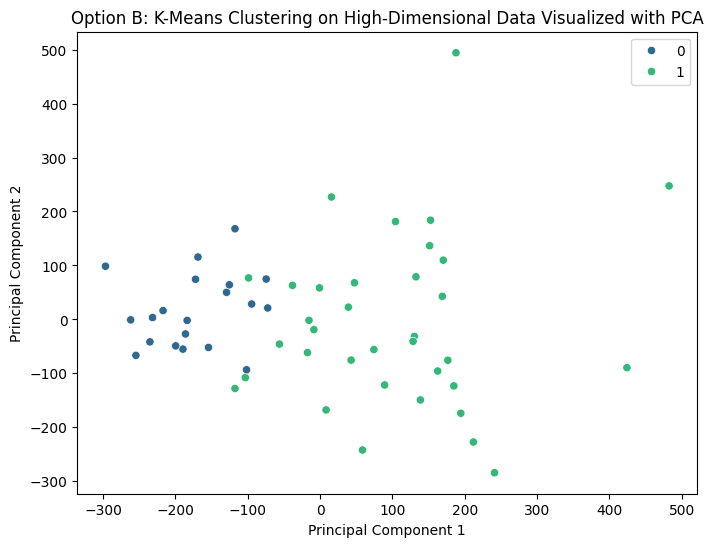

In [23]:
# Dimensionality Reduction for visualization
print("Dimensionality Reduction for Visualization\n")

# Using PCA to reduce to 2 components for visualization
pca_vis = PCA(n_components=2)
features_pca_vis = pca_vis.fit_transform(flattened_features_std)
explained_variance_vis = np.sum(pca_vis.explained_variance_ratio_)
print(f"PCA for visualization - Explained variance: {explained_variance_vis:.4f}")

# Visualize clusters obtained from high-dimensional clustering
plt.figure(figsize=(8,6))
sns.scatterplot(x=features_pca_vis[:, 0], y=features_pca_vis[:, 1], hue=clusters_highdim_kmeans, palette='viridis')
plt.title('Option B: K-Means Clustering on High-Dimensional Data Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()